# Advanced Tutorial 7: Learning Rate Scheduling

## Overview
In this tutorial we will talk about:
* **Customizing Learning Rate schedule function**
    * epoch-wise
    * step-wise
* **Using built-in lr_schedule function**
    * cosine decay

Learning rate schedules can be implemented using **LRScheduler** trace. LRScheduler takes the model and learning schedule through the **lr_fn** parameter. **lr_fn** should be a function/lambda function with step or epoch as parameter. This determines whether learning schedule will be applied at a step or epoch level.

For more details on traces, you can visit [tutorial 7](https://github.com/fastestimator/fastestimator/blob/master/tutorial/beginner/t07_estimator.ipynb) in beginner section and [tutorial 4](https://github.com/fastestimator/fastestimator/blob/master/tutorial/advanced/t04_trace.ipynb) in the advanced section. 

Let's create a function to generate pipeline, model and network to be used for the tutorial

In [1]:
import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


def get_pipeline_model_network(model_name="LeNet"):
    train_data, _ = mnist.load_data()

    pipeline = fe.Pipeline(train_data=train_data,
                           batch_size=32,
                           ops=[ExpandDims(inputs="x", outputs="x"), 
                                Minmax(inputs="x", outputs="x")])

    model = fe.build(model_fn=LeNet, optimizer_fn="adam", model_names=model_name)

    network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce")
    ])

    return pipeline, model, network

## Customizing Learning Rate schedule function
We can specify custom learning schedule by passing a custom function to the **lr_fn** parameter of LRScheduler. We can specify learning rate schedule to be applied at epoch or step level. Epoch and step start from 1.

### Epoch-wise
To apply learning rate at epoch level, the custom function should have epoch as a parameter. Let's look at the example below which demonstrates this. We will be using summary parameter in the fit method to be able to visualize the learning rate later. You can go through [Tutorial 6](https://github.com/fastestimator/fastestimator/blob/master/tutorial/advanced/t06_summary.ipynb) in the advanced section for more details on accessing training history.

In [2]:
from fastestimator.summary.logs import visualize_logs
from fastestimator.trace.adapt import LRScheduler

def lr_schedule(epoch):
    lr = 0.001*(20-epoch+1)/20
    return lr

pipeline, model, network = get_pipeline_model_network()

traces = LRScheduler(model=model, lr_fn=lr_schedule)
estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=3, traces=traces)

history = estimator.fit(summary="Experiment_1")

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; LeNet_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.2990923; LeNet_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.4943217; steps/sec: 248.6; LeNet_lr: 0.001; 
FastEstimator-Train: step: 200; ce: 0.21011522; steps/sec: 251.18; LeNet_lr: 0.001; 
FastEstimator-Train: step: 300; ce: 0.050100736; steps/sec: 251.31; LeNet_lr: 0.001; 
FastEstimator-Train: step: 400; ce: 0.022691462; steps/sec: 254.55; LeNet_lr: 0.001; 
FastEstimator-Train: step: 500; ce

The learning rate is available during training log at steps specified using log_steps parameter in the estimator. By default, training is logged at every 100 steps.

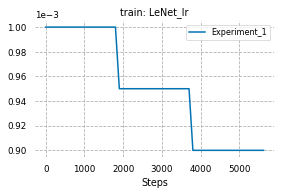

In [3]:
visualize_logs(history, include_metrics="LeNet_lr")

As you can see, the learning rate changes only at an epoch level

### Step-wise
The custom function should have step as a parameter for step based learning schedules. 

In [4]:
def lr_schedule(step):
    lr = 0.001*(7500-step+1)/7500
    return lr

pipeline, model, network = get_pipeline_model_network()

traces = LRScheduler(model=model, lr_fn=lr_schedule)
estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=2, traces=traces)

history2 = estimator.fit(summary="Experiment_2")

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; LeNet_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.2912364; LeNet_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.31862932; steps/sec: 240.19; LeNet_lr: 0.0009868; 
FastEstimator-Train: step: 200; ce: 0.34517264; steps/sec: 239.47; LeNet_lr: 0.00097346667; 
FastEstimator-Train: step: 300; ce: 0.12563829; steps/sec: 237.09; LeNet_lr: 0.00096013333; 
FastEstimator-Train: step: 400; ce: 0.19191661; steps/sec: 240.71; LeNet_lr: 0.0009468; 
FastEstima

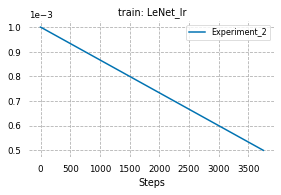

In [5]:
visualize_logs(history2, include_metrics="LeNet_lr")

## Using built-in lr_schedule function
Some learning rates schedules are widely popular in the deep learning community. So, we have implemented some of them in fastestimator so that you don't need to write a custom schedule for them. We will be showcasing `cosine decay` schedule below.

### cosine_decay
We can specify the length of the decay cycle and initial learning rate using cycle_length and init_lr respectively. Similar to custom learning schedule, lr_fn should have step or epoch as a parameter. Implementation of cosine decay is shown below:

In [6]:
from fastestimator.schedule import cosine_decay

pipeline, model, network = get_pipeline_model_network()

traces = LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=1875, init_lr=1e-3))
estimator = fe.Estimator(pipeline=pipeline, network=network, epochs=2, traces=traces)

history3 = estimator.fit(summary="Experiment_3")

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; LeNet_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.30225; LeNet_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.5218753; steps/sec: 230.78; LeNet_lr: 0.0009931439; 
FastEstimator-Train: step: 200; ce: 0.035484873; steps/sec: 244.72; LeNet_lr: 0.0009724906; 
FastEstimator-Train: step: 300; ce: 0.17100406; steps/sec: 236.97; LeNet_lr: 0.00093861774; 
FastEstimator-Train: step: 400; ce: 0.07232281; steps/sec: 238.56; LeNet_lr: 0.0008924742; 
FastEst

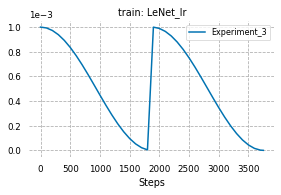

In [7]:
visualize_logs(history3, include_metrics="LeNet_lr")